# Build a co-authorship Network

The nodes are authors and the edges are co-authorship (undirected). The width of the edge is the frequency of co-authoring. Other modification could be: 
* color of edge is the year of publication
* nodes are colored by publication
* nodes are sized by centrality, tenure of authors (if we would have that)

In [1]:
import scraper as sc
import pandas as pd
from collections import defaultdict

import networkx as nx

import pickle as pk
import numpy as np
from scipy import sparse as sp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
retmax = 100
email = 'kbohlec@gmail.com'

In [3]:
def make_query(term, year):
    return '({}[Title/Abstract]) AND \
({}[Date - Publication])'\
.format(term, year)

In [4]:
make_query('parkinson\'s', 2016)

"(parkinson's[Title/Abstract]) AND (2016[Date - Publication])"

In [5]:
# rough, should probably be using a defaultdict here
for i, n in enumerate(range(2000,2019,1)):
    new_keys = range(i*retmax, (i+1)*retmax)
    query = make_query('parkinson\'s', n)
    ap = sc.ArticleParser(retmax, email)
    raw_dict = ap.find_term(query)
    articles = ap.fetch_info(raw_dict['IdList'])
    if i == 0:
        parsed_dict = ap.parse_info(articles)
    else:
        n_parsed_dict = ap.parse_info(articles)
        for k in n_parsed_dict.keys():
            parsed_dict[new_keys[k]] = n_parsed_dict[k] # add articles from the next year behind the current  

There are no citations for article 0

There are no citations for article 1

There are no citations for article 2

There are no citations for article 3

There's no abstract for article 3

There's no abstract for article 4

There's no author info for article 5

There are no citations for article 5

There are no citations for article 6

There are no citations for article 7

There are no citations for article 9

There's no author info for article 10

There are no citations for article 10

There's no abstract for article 10

There are no citations for article 11

There are no citations for article 12

There are no citations for article 13

There's no abstract for article 13

There are no citations for article 14

There are no citations for article 15

There's no abstract for article 16

There are no citations for article 17

There are no citations for article 18

There are no citations for article 19

There are no citations for article 20

There are no citations for article 21

There are no

In [6]:
df = pd.DataFrame.from_dict(parsed_dict, orient = 'index')
df.date = pd.to_datetime(df.date)
df = df[df.abstract != ''].sort_values(by='date', 
                                       ascending=0)\
                          .reset_index(drop=True)
df.head()

,title,date,authors,published in,citations,abstract
0,Chemical Probe To Monitor the Parkinsonism-Ass...,2018-07-19,"Jonas Drechsel, Franziska A Mandl, Stephan A S...",ACS chemical biology,,Reactive oxygen species (ROS) play an importan...
1,A minimally invasive neurostimulation method f...,2018-07-19,"Malbor Asllani, Paul Expert, Timoteo Carletti",PLoS computational biology,,Many collective phenomena in Nature emerge fro...
2,Mode-Selective Raman Imaging of Dopamine-Human...,2018-07-19,"Achut Prasad Silwal, H Peter Lu",ACS chemical neuroscience,,Dopamine (DA) is the catecholamine neurotransm...
3,"Parkinson disease, temporomandibular disorders...",2018-07-19,"Merel Verhoeff, Frank Lobbezoo, Peter Wetselaa...",Journal of oral rehabilitation,,Even though bruxism and Parkinson's disease (P...
4,Gastrointestinal nervous system α-synuclein as...,2018-07-18,"Fudong Yan, Ying Chen, Min Li, Yingqing Wang, ...",Medicine,,Lewy bodies (LB) play an essential role in the...


## Create network

The authors are listed in one cell separated by coma. *Assumption: Author names are correct. Each spelling of a name is a unique author. This is often the wrong assumption to have*.
Check about [*Author Name Disambiguation (AND)*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5887226/).
This [Kaggle Notebook by Yasmin](https://www.kaggle.com/ykhorramz/network-viz-nips-15-co-authorship-network/notebook) is pretty useful. 

In [7]:
plt.style.use('seaborn-whitegrid')

title_font = {'size':'18', 'color':'black', 'verticalalignment':'bottom',  'fontstyle':'bold'} 
axis_font = { 'size':'14'}

## Create a data frame with title - authors.

Author need to be split at comma

In [9]:
df.head(2)

,title,date,authors,published in,citations,abstract,authors2
0,Chemical Probe To Monitor the Parkinsonism-Ass...,2018-07-19,"Jonas Drechsel, Franziska A Mandl, Stephan A S...",ACS chemical biology,,Reactive oxygen species (ROS) play an importan...,"[Jonas Drechsel, Franziska A Mandl, Stephan A ..."
1,A minimally invasive neurostimulation method f...,2018-07-19,"Malbor Asllani, Paul Expert, Timoteo Carletti",PLoS computational biology,,Many collective phenomena in Nature emerge fro...,"[Malbor Asllani, Paul Expert, Timoteo Carletti]"


In [10]:
# https://gist.github.com/jlln/338b4b0b55bd6984f883

def splitDataFrameList(df,target_column,separator):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    def splitListToRows(row,row_accumulator,target_column,separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    new_df = pd.DataFrame(new_rows)
    return new_df

In [11]:
#splitDataFrameList(df, df['authors'], ',') 

In [12]:
df_split = splitDataFrameList(df, 'authors', ',')

In [13]:
df_split[0:5]

,abstract,authors,authors2,citations,date,published in,title
0,Reactive oxygen species (ROS) play an importan...,Jonas Drechsel,"[Jonas Drechsel, Franziska A Mandl, Stephan A ...",,2018-07-19,ACS chemical biology,Chemical Probe To Monitor the Parkinsonism-Ass...
1,Reactive oxygen species (ROS) play an importan...,Franziska A Mandl,"[Jonas Drechsel, Franziska A Mandl, Stephan A ...",,2018-07-19,ACS chemical biology,Chemical Probe To Monitor the Parkinsonism-Ass...
2,Reactive oxygen species (ROS) play an importan...,Stephan A Sieber,"[Jonas Drechsel, Franziska A Mandl, Stephan A ...",,2018-07-19,ACS chemical biology,Chemical Probe To Monitor the Parkinsonism-Ass...
3,Many collective phenomena in Nature emerge fro...,Malbor Asllani,"[Malbor Asllani, Paul Expert, Timoteo Carletti]",,2018-07-19,PLoS computational biology,A minimally invasive neurostimulation method f...
4,Many collective phenomena in Nature emerge fro...,Paul Expert,"[Malbor Asllani, Paul Expert, Timoteo Carletti]",,2018-07-19,PLoS computational biology,A minimally invasive neurostimulation method f...


In [14]:
''' First need to map both author and paper ids to start
    from zero so that we can store them in a numpy array. '''

int_pid = dict(enumerate(list(df_split.title.unique())))
int_aid = dict(enumerate(list(df_split.authors.unique())))

pid_intid = {v:k for k,v in int_pid.items()}
aid_intid = {v:k for k,v in int_aid.items()}


In [15]:
ap_tuples = list(zip(df_split.authors, df_split.title))
ap_int_tups =  [(aid_intid[i[0]], pid_intid[i[1]]) for i in ap_tuples]
''' AP: matrix of author-paper, AP[i, j]=1 indicates that author i has published paper j '''
AP = sp.csc_matrix((np.ones(len(ap_int_tups)), zip(*ap_int_tups)))

In [16]:
AP[:,].toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [17]:
''' AA: the author-author matrix, 
    AA[i, j]=1 indicates that author i has published a paper with author j '''

AA = AP.dot(AP.T)

In [18]:
print("Only {:.4%} of potential author-author connections exists.".format(0.01*len(AA.nonzero()[1])/float(AA.shape[0]**2)))

Only 0.0009% of potential author-author connections exists.


In [19]:
'Remove self-loops'
AA = np.array(AA - np.diag(AA.diagonal()))

'Weighted graph'
G = nx.from_numpy_matrix(AA, parallel_edges=True)

## Compute network centrality measures to add to authors dataframe

In [20]:
'''number of co-authors per member '''
node_deg = nx.degree(G) 

'''normalized number of co-authors ( with what fraction of NIPS authors he wrote a paper) '''
deg_cent = nx.degree_centrality(G) 

'''fraction of the number of times the author appears on the path connecting two other authors '''
bet_cent = nx.betweenness_centrality(G)

In [21]:
df_split['Degree'] = df_split['authors'].apply(lambda l: node_deg[aid_intid.get(l)])
df_split['Deg_Cent'] = df_split['authors'].apply(lambda l: deg_cent[aid_intid.get(l)])
df_split['Betweenness'] = df_split['authors'].apply(lambda l: bet_cent.get(aid_intid.get(l)))

In [22]:
# Rescaling the betweenness measure
df_split['Bet_Norm'] = df_split['Betweenness'].apply(lambda l: np.arcsinh(l+1e-6))

In [23]:
df_split.head(2)

,abstract,authors,authors2,citations,date,published in,title,Degree,Deg_Cent,Betweenness,Bet_Norm
0,Reactive oxygen species (ROS) play an importan...,Jonas Drechsel,"[Jonas Drechsel, Franziska A Mandl, Stephan A ...",,2018-07-19,ACS chemical biology,Chemical Probe To Monitor the Parkinsonism-Ass...,2,0.00021,0.0,1.000000e-06
1,Reactive oxygen species (ROS) play an importan...,Franziska A Mandl,"[Jonas Drechsel, Franziska A Mandl, Stephan A ...",,2018-07-19,ACS chemical biology,Chemical Probe To Monitor the Parkinsonism-Ass...,2,0.00021,0.0,1.000000e-06


degree is very, very low. 

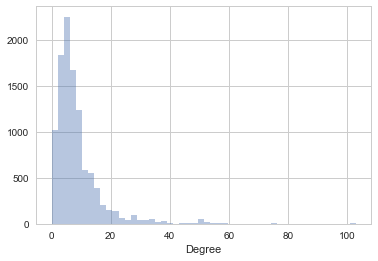

In [24]:
sns.distplot(df_split['Degree'], kde=False)

Long tail degree distribution. Normal for social networks

In [ ]:
print("The network has {} edges, {} auhtors, and a density of {:.3}.".format(G.number_of_edges(), 
                                                                                       G.number_of_nodes(), 
                                                                                       nx.density(G)))

The network has 37029 edges, 9514 auhtors, and a density of 0.000818.


In [ ]:
from networkx.drawing.nx_agraph import graphviz_layout
#pos = graphviz_layout(G) #problem with installing graphviz and therefore can't install pygraphviz
pos= nx.spring_layout(G, iterations=50)

In [ ]:
labels=[]
group=[]
for node in G.nodes():
    labels.append(int_aid[node])
    group.append(df_split['published in'][node])

In [ ]:
len(set(labels))

In [ ]:
len(set(group))

In [ ]:
nx.draw(G)
pl.show()

In [191]:
''' Hovering over nodes, display author names 
    Mapping author IDs to names '''
aid_name = df.authors

In [193]:
import plotly.plotly as py
from plotly.graph_objs import *
#edge_trace = Scatter(
#    x=[],
#    y=[],
#    line=Line(width=1.5,color='#888'),
#    hoverinfo='none',
#    mode='lines') # change this

for edge in G.edges(data=True):
    
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
#    edge_trace['x'] += (x0, x1, None)
#    edge_trace['y'] += (y0, y1, None)

node_trace = Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=Marker(
        showscale=True,
        colorscale='Jet',
        color=group,
        size=[],
        colorbar=dict(
            title='Class',
            tickvals = [i for i in range(4)],
            ticktext = [cls_name[i] for i in range(4)],
            ticks = 'outside'
        ),
        line=dict(width=1)))

for node in G.nodes():
    x, y = pos[node]#G.node[node]['pos']
    node_trace['x'].append(x)
    node_trace['y'].append(y)

/Users/katerinadoyle/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:372: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




KeyboardInterrupt: 

do without hovering over. this takes ages.

In [ ]:
node_deg = G.degree()
node_trace['marker']['size'] =[]
node_trace['marker']['color'] =[]
node_trace['text'] =[]
for node in G.nodes():
    node_trace['marker']['size'].append(4*(node_deg[node]))
    name = aid_name.get(int_aid[node])
    node_info = '# of connections: %s <br />AuthorID: %s'%(str(node_deg[node]), str(name))

    node_trace['text'].append(node_info)
    node_trace['marker']['color'].append(author_cls[int_aid[node]])

In [ ]:
fig = Figure(data=Data([edge_trace, node_trace]),
             layout=Layout(
                title='<br>Coauthorship Network',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=10,l=15,r=5,t=40),
                xaxis=XAxis(autorange=True, showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(autorange=True, showgrid=False, zeroline=False, showticklabels=False)))

plotly.iplot(fig, filename='coauthorship_network_vis')

In [ ]:
fig = Figure(data=)

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(x="parent_category_name", y="deal_probability", data=train_df)
plt.ylabel('Deal probability', fontsize=12)
plt.xlabel('Parent Category', fontsize=12)
plt.title("Deal probability by parent category", fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

In [35]:
import matplotlib

/Users/katerinadoyle/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/katerinadoyle/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/katerinadoyle/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/Users/katerinadoyle/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be 

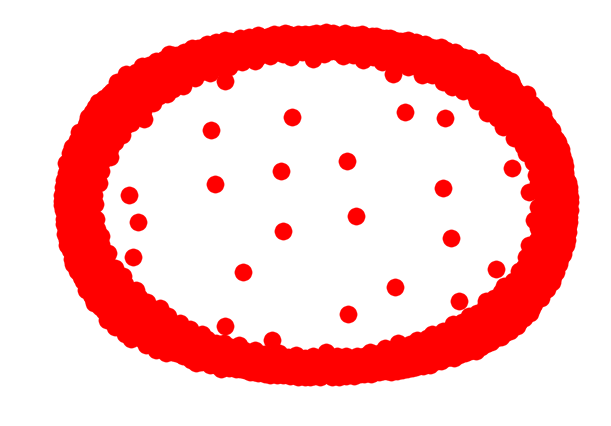

In [34]:
nx.draw(G)